# Multilabel classification problem solution for Reuters-21578

### AIM OF THE PROJECT
The objetive of this project is to test different appraches to NLP problem of multilabel classification and find optimal model that would properly predict document "subject" labels based on a raw document text. <br>
<br><br>
The multilabel classification is a classification for which:
* Number of targets >1
* Number of targets for each sample is a-priori unknown and can differ for different samples
* Target cardinality is equal to 2 (0 or 1) == the sample belongs to a certain target (category) or not

### DATASET USED
Reuters-21578

The full set is available here:
https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection

For the project needs, the author used dataset available in NLTK library which is already split to train and test. It can be loaded to the memory by a command:
*from nltk.corpus import reuters*

The dataset contains:
* almost 8000 train articles
* over 3000 test articles
* there is 90 unique labels
* In average only 1.23 labels are assigned to each train set article

### SUMMARY OF THE PROJECT

#### DATA CLEANING

Before applying a model - the data was cleaned, tokenized and normlized.

#### DATA PRE-PROCESSING

In order to find a best approach to this problem, three different approaches were taken for the words embedding:
* tf-idf
* Doc2Vec (in 2 ways: training the model on the train corpus, using the pre-trained model)
* FastText (in 2 ways as above)

#### MODELLING

1. The target labels were binarized with MultiLabelBinarizer
2. A few different models were fitted using pipeline and GridSearchCV (for different pre-processing methods):
    * Inherently supporting multilabels:
        * k-nearest neighbors
        * Random Forest
    * OneVsRest with Linear SVM
    * Label Powerset with Linear SVM
    * Convolutional Neural Network

#### METRICS
As in multilabel  - the sample belongs to few labels out of all set of labels, the absolute accuracy is not a good measure (as it will tag as correct only these samples which have all set of labels correclty predicted, without taking into account partial correctness (e.g. we predict correctly 3 out of 4 labels)).
It is proposed to use hamming loss function which would take into account partial correctness.

Each individual category predictions can be evaluated based on traditional metrics like F1 score, Precision and Recall, however, to evaluate full multilabel model, these metrics for each category shall be averaged. There are 2 approaches to do that: micro and macro.

Finally for this project, it was decided to evaluate the model based on a hamming loss and micro & macro f1-score.

Find explanation of micro and macro averaging here:
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [8]:
import numpy as np
import pandas as pd
import re
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

import nltk # text cleaning and datasets 
import re # patterns searching in strings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, multilabel_confusion_matrix, hamming_loss

#### Import data from nltk.corpus and establish train/test inputs and targets

In [9]:
from nltk.corpus import reuters

In [10]:
all_docs = reuters.fileids()
train_doc_names = [doc for doc in all_docs if doc.startswith("train")]
test_doc_names = [doc for doc in all_docs if doc.startswith("test")]

In [11]:
X_train_raw, y_train_raw = zip(*[(reuters.raw(doc), reuters.categories(doc)) for doc in train_doc_names])
X_test_raw, y_test_raw= zip(*[(reuters.raw(doc), reuters.categories(doc)) for doc in test_doc_names])

### Review the data:

In [12]:
# Number of articles:
print(f"Number of train articles: {len(X_train_raw)}")
print(f"Number of test articles: {len(X_test_raw)}")

Number of train articles: 7769
Number of test articles: 3019


#### Review labels

In [13]:
y_train_raw_flat = pd.Series(itertools.chain(*y_train_raw))
y_test_raw_flat = pd.Series(itertools.chain(*y_train_raw))

In [14]:
print(f"Avg number of labels per article in train set: {(len(y_train_raw_flat) / len(y_train_raw) ):.2f}")
# print(f"Avg number of labels per article in test set: {(len(y_test_raw_flat) / len(y_test_raw) ):.2f}")

Avg number of labels per article in train set: 1.23


In [15]:
# Count number of labels for each article
labels_len = [len(labels) for labels in y_train_raw]
# Group 
labels_freq = {n: labels_len.count(n) for n in labels_len}
labels_freq = dict(sorted(labels_freq.items()))
print(f"Number of labels assigned to article: Total number of such occurances")
labels_freq

Number of labels assigned to article: Total number of such occurances


{1: 6577,
 2: 865,
 3: 192,
 4: 59,
 5: 37,
 6: 22,
 7: 5,
 8: 5,
 9: 3,
 10: 2,
 11: 1,
 15: 1}

Conclusion: For most of the cases in the train set - there is only 1 label associated with article.

#### Review classes

In [16]:
print(f"Total number of classes: {len(reuters.categories())}")

Total number of classes: 90


In [17]:
cat_distr = y_train_raw_flat.value_counts()
cat_distr.head(5)

earn        2877
acq         1650
money-fx     538
grain        433
crude        389
dtype: int64

In [18]:
cat_distr.tail(5)

cotton-oil       1
castor-oil       1
rye              1
groundnut-oil    1
lin-oil          1
dtype: int64

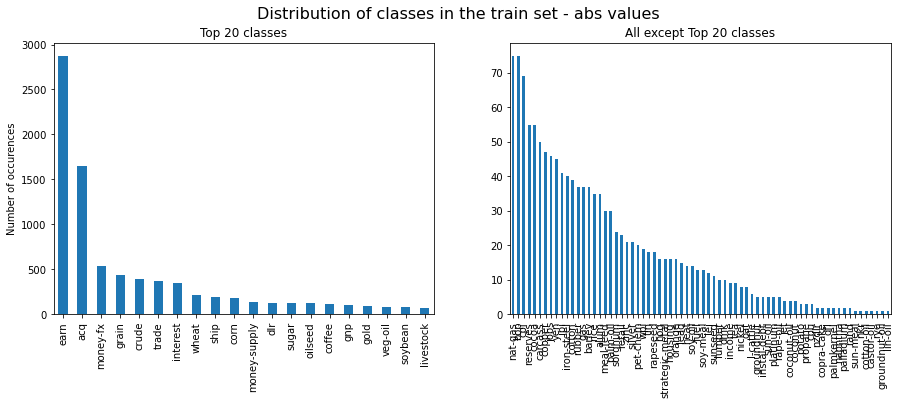

In [19]:
n=20 # split between left and right graph (number of top classes)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of classes in the train set - abs values', fontsize = 16)

plt.subplot(1,2,1)
cat_distr[:n].plot.bar()
plt.ylabel(f'Number of occurences');
plt.title(f'Top {n} classes');

plt.subplot(1,2,2)
cat_distr[n:].plot.bar()
plt.title(f'All except Top {n} classes');

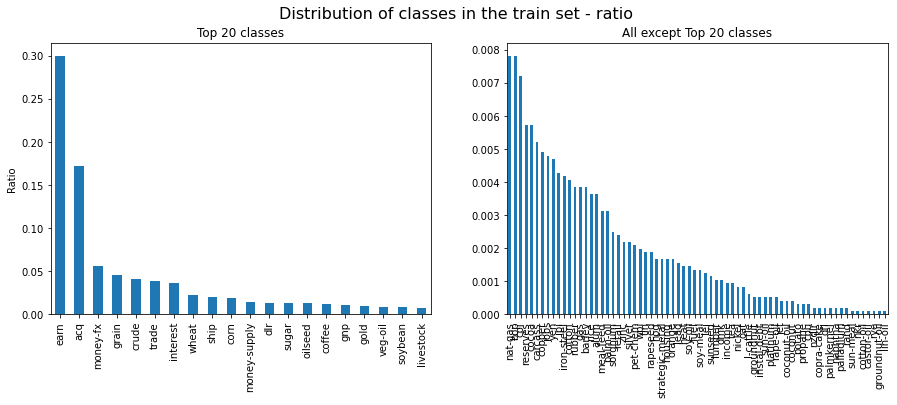

In [20]:
n=20 # split between left and right graph (number of top classes)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of classes in the train set - ratio', fontsize = 16)

plt.subplot(1,2,1)
(cat_distr[:n]/cat_distr.sum()).plot.bar()
plt.ylabel(f'Ratio');
plt.title(f'Top {n} classes');

plt.subplot(1,2,2)
(cat_distr[n:]/cat_distr.sum()).plot.bar()
plt.title(f'All except Top {n} classes');

Conclusion: Top 2 classes are far more frequent than other classes (more than 45% of all targets)

#### Review the raw articles

In [21]:
type(X_train_raw[0])

str

In [22]:
art_len = [len(art) for art in X_train_raw]

In [23]:
print(f"Character count for the shortest article: {min(art_len)}")
print(f"Character count for the longest article: {max(art_len)}")

Character count for the shortest article: 27
Character count for the longest article: 8898


In [24]:
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
# ax1.hist(art_len, bins=50, rwidth = 0.9);

(0.0, 200.0)

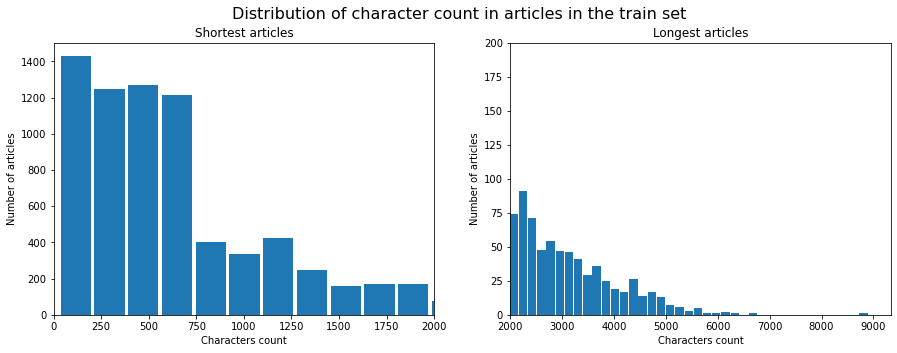

In [25]:
n=2000 # split between left and right graph (number of characters)
plt.figure(figsize=(15,5))
plt.suptitle('Distribution of character count in articles in the train set', fontsize = 16)

plt.subplot(1,2,1)
plt.hist(art_len, bins=50, rwidth = 0.9);
plt.ylabel(f'Number of articles');
plt.xlabel(f'Characters count');
plt.title(f'Shortest articles');
plt.xlim(0,n)

plt.subplot(1,2,2)
plt.hist(art_len, bins=50, rwidth = 0.9);
plt.ylabel(f'Number of articles');
plt.xlabel(f'Characters count');
plt.title(f'Longest articles');
plt.xlim(n,)
plt.ylim(0,200)

# plt.tight_layout()
# ax.set(ylabel = 'aaa')

In [26]:
X_train_raw[0][:300]

'BAHIA COCOA REVIEW\n  Showers continued throughout the week in\n  the Bahia cocoa zone, alleviating the drought since early\n  January and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  Comissaria Smith said in its weekly review.\n      The dry p'

<br><br><br>
### Side analysis START

In [27]:
min(X_train_raw, key=len)

'26-FEB-1987\n  26-FEB-1987\n\n'

In [28]:
min(X_train_raw)

' 1-APR-1987 17:39:30.41\n   1-APR-1987 17:39:30.41\n\n'

In [29]:
X_train_raw.index(min(X_train_raw, key=len))

66

In [30]:
X_train_raw.index(min(X_train_raw))

1533

In [31]:
y_train_raw[1533]

['grain', 'ship']

In [32]:
y_train_raw[66]

['money-supply']

### Side analysis END

<br><br><br>
### Clean text

#### Functions definition

In [33]:
def remove_html(text_list):
    text_clean = [re.sub("<.+?>", " ", el) for el in text]
    return text_clean

In [34]:
def convert_to_lower(text):
    text_clean = [el.lower() for el in text]
    return text_clean

In [35]:
def remove_control_chars(text): # (e.g. \n \t...)
    text_clean = [re.sub("\s+", " ", el) for el in text]
    return text_clean

In [36]:
def tokenization(text):
    text_clean = [nltk.word_tokenize(el) for el in text]
    return text_clean

In [37]:
def remove_stopwords(text):
    stopwords =nltk.corpus.stopwords.words("english")
    text_clean = [[w for w in el if w not in stopwords] for el in text]
    return text_clean

In [38]:
def remove_punctuations(text):
    import string
    punctuations = [char for char in string.punctuation]
    
    text_clean = [[w for w in el if w not in punctuations] for el in text]
    return text_clean

In [39]:
def token_normalization(text):
    # Token normalization - stemming with PorterStemmer 
    # It is not important to keep "real" language words, so stemming (as being faster) is a better choice than lemmatization
    stemmer = nltk.PorterStemmer()
    
    text_clean = [[stemmer.stem(w) for w in el] for el in text]
    return text_clean

In [40]:
def remove_numbers(text):
    
    text_clean = [[re.sub('[^A-Za-z]+', '', w) for w in el] for el in text]
    # Remove empty strings after number removal
    text_clean = [list(filter(None, el)) for el in text_clean]
    
    return text_clean

In [41]:
def remove_short_words(text, k):
    text_clean = [[w for w in el if len(w) > k] for el in text]
    return text_clean

In [42]:
def merge_back(text):
    text_merge = [" ".join(el) for el in text]
    return text_merge

In [125]:
# Combine all functions above
def text_preprocess(text):
#     text = remove_html(text)
    text = convert_to_lower(text)
    text = remove_control_chars(text)
    tokens = tokenization(text)
    tokens = remove_stopwords(tokens)
    tokens = remove_punctuations(tokens)
    tokens = token_normalization(tokens)
    tokens = remove_numbers(tokens)
    text = remove_short_words(tokens, 2)
    text_final = merge_back(text)
    
    return tokens, text_final

#### Let's apply cleaning functions on train set:

In [44]:
# Convert to lower case
X_train =  convert_to_lower(X_train_raw)
X_train[0][:300]

'bahia cocoa review\n  showers continued throughout the week in\n  the bahia cocoa zone, alleviating the drought since early\n  january and improving prospects for the coming temporao,\n  although normal humidity levels have not been restored,\n  comissaria smith said in its weekly review.\n      the dry p'

In [45]:
# Remove control characters
X_train =  remove_control_chars(X_train)
X_train[0][:300]

'bahia cocoa review showers continued throughout the week in the bahia cocoa zone, alleviating the drought since early january and improving prospects for the coming temporao, although normal humidity levels have not been restored, comissaria smith said in its weekly review. the dry period means the '

In [46]:
# Tokenization
X_train = tokenization(X_train)
print(X_train[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'the', 'week', 'in', 'the', 'bahia', 'cocoa', 'zone', ',', 'alleviating', 'the', 'drought', 'since', 'early', 'january']


In [47]:
# Remove stopwords
X_train = remove_stopwords(X_train)
print(X_train[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'week', 'bahia', 'cocoa', 'zone', ',', 'alleviating', 'drought', 'since', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao']


In [48]:
# Remove punctuations
X_train = remove_punctuations(X_train)
print(X_train[0][:20])

['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'alleviating', 'drought', 'since', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao', 'although']


In [49]:
# Token normalization
X_train = token_normalization(X_train)
print(X_train[0][:50])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', '22', '155,221', 'bag', '60', 'kilo', 'make', 'cumul', 'total', 'season', '5.93', 'mln']


In [50]:
# Remove numbers 
# Consider converting all numbers to "number" string instead of removing them ???
X_train = remove_numbers(X_train) 
print(X_train[0][:50])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', 'bag', 'kilo', 'make', 'cumul', 'total', 'season', 'mln', 'stage', 'last', 'year', 'seem']


In [51]:
# Remove words shorter than 2
X_train = remove_short_words(X_train, 2)
print(X_train[0][:60])

['bahia', 'cocoa', 'review', 'shower', 'continu', 'throughout', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'sinc', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'although', 'normal', 'humid', 'level', 'restor', 'comissaria', 'smith', 'said', 'weekli', 'review', 'dri', 'period', 'mean', 'temporao', 'late', 'year', 'arriv', 'week', 'end', 'februari', 'bag', 'kilo', 'make', 'cumul', 'total', 'season', 'mln', 'stage', 'last', 'year', 'seem', 'cocoa', 'deliv', 'earlier', 'consign', 'includ', 'arriv', 'figur', 'comissaria', 'smith', 'said']


In [52]:
tokens_train = X_train

In [53]:
X_train = merge_back(X_train)
X_train[0][:500]

'bahia cocoa review shower continu throughout week bahia cocoa zone allevi drought sinc earli januari improv prospect come temporao although normal humid level restor comissaria smith said weekli review dri period mean temporao late year arriv week end februari bag kilo make cumul total season mln stage last year seem cocoa deliv earlier consign includ arriv figur comissaria smith said still doubt much old crop cocoa still avail harvest practic come end total bahia crop estim around mln bag sale '

#### Let's review frequency and size of cleaned data:

In [89]:
indexes = [word for doc in tokens_train for word in doc]  

In [90]:
from collections import Counter

In [292]:
# Most frequent words:
corpus_freq = Counter(indexes).most_common()
corpus_freq[:10]

[('said', 18844),
 ('mln', 13102),
 ('dlr', 9750),
 ('pct', 7406),
 ('year', 6010),
 ('net', 4566),
 ('loss', 4312),
 ('share', 4184),
 ('billion', 4110),
 ('compani', 4037)]

In [86]:
uniques = [word for word,freq in Counter(indexes).items() if freq == 1]

In [95]:
print(f"There are {len(indexes)} words in the train corpus,")
print(f"within which we have {len(Counter(indexes))} unique words,")
print(f"out of which there are {len(uniques)} words that appear only once the train corpus!")

There are 596080 words in the train corpus,
within which we have 19850 unique words,
out of which there are 7983 words that appear only once the train corpus!


#### Let's do the same cleaning transofrmations with test set (using combined function)

In [128]:
tokens_test, X_test = text_preprocess(X_test_raw)

In [130]:
tokens_test[0][:10]

['asian',
 'export',
 'fear',
 'damag',
 'usjapan',
 'rift',
 'mount',
 'trade',
 'friction',
 'us']

<br><br><br>
## Text vectorization
Plan to review TFIDF, FastText, doc2vec

What about Skip-Thought Vectors??

### TFIDF

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TfidfVectorizer?

In [173]:
min_df = 3
max_df = 0.8

In [174]:
tfidf_vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df)

tfidf = tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)

X_test_tfidf = tfidf.transform(X_test)

In [175]:
print(f"Number of remaining tokens: {X_train_tfidf.shape[1]}")

Number of remaining tokens: 7188


In [176]:
# Take a dense tfidf with feature names
df_tfidf = pd.DataFrame(X_train_tfidf.todense().T, index=tfidf.get_feature_names())

In [177]:
df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,7759,7760,7761,7762,7763,7764,7765,7766,7767,7768
aaa,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aac,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aar,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abandon,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abat,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zoet,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zone,0.044526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zorinski,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zuccherifici,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
doc = 0
df_tfidf.loc[df_tfidf[doc] > 0, [doc]]

,0
allevi,0.056771
almost,0.038594
also,0.020205
although,0.033906
aprilmay,0.055303
...,...
went,0.043398
would,0.019074
year,0.029054
york,0.258704


In [179]:
df_tfidf.shape

(7188, 7769)

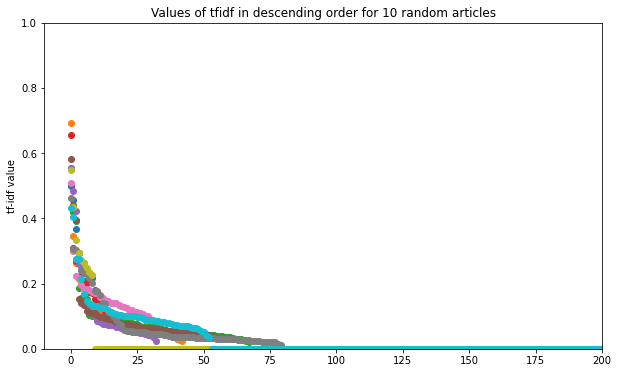

In [180]:
import random
n = 10 # Number of articles to be presented
randomlist = random.sample(range(0, X_train_tfidf.shape[0]), n)

plt.figure(figsize=(10,6))

for i in randomlist:
    rowssort = X_train_tfidf.getrow(i).todense().A1.argsort()[::-1]
    valsort = df_tfidf[i].values[rowssort]
    
    plt.plot(valsort, 'o')

ax = plt.gca()
ax.set(xlim=(-10, 200), ylim=(0, 1),
       ylabel='tf-idf value',
       title=f'Values of tfidf in descending order for {n} random articles');


### Doc2vec

In [716]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import multiprocessing

In [715]:
TaggedDocument

gensim.models.doc2vec.TaggedDocument

### Let's train my own model:

In [182]:
# Create train corpus objects from tokenized train set 
D2V_train_corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens_train)]

In [1150]:
D2V_train_corpus[1]

TaggedDocument(words=['comput', 'termin', 'system', 'cpml', 'complet', 'sale', 'comput', 'termin', 'system', 'inc', 'said', 'complet', 'sale', 'share', 'common', 'stock', 'warrant', 'acquir', 'addit', 'one', 'mln', 'share', 'sedio', 'lugano', 'switzerland', 'dlr', 'compani', 'said', 'warrant', 'exercis', 'five', 'year', 'purchas', 'price', 'dlr', 'per', 'share', 'comput', 'termin', 'said', 'sedio', 'also', 'right', 'buy', 'addit', 'share', 'increas', 'total', 'hold', 'pct', 'comput', 'termin', 'outstand', 'common', 'stock', 'certain', 'circumst', 'involv', 'chang', 'control', 'compani', 'compani', 'said', 'condit', 'occur', 'warrant', 'would', 'exercis', 'price', 'equal', 'pct', 'common', 'stock', 'market', 'price', 'time', 'exceed', 'dlr', 'per', 'share', 'comput', 'termin', 'also', 'said', 'sold', 'technolgi', 'right', 'dot', 'matrix', 'impact', 'technolog', 'includ', 'futur', 'improv', 'woodco', 'inc', 'houston', 'tex', 'dlr', 'said', 'would', 'continu', 'exclus', 'worldwid', 'licen

In [717]:
# Params:
vector_size = 100 # Same as we will use for CNN model
min_count= 3 # Same as for tfidf

cores = multiprocessing.cpu_count()-1

In [719]:
# Create model
model_Doc2Vec =  Doc2Vec(D2V_train_corpus, vector_size = vector_size, min_count = min_count, window = 4, epochs = 40, workers=cores)

In [720]:
# Train model on train corpus
model_Doc2Vec.train(D2V_train_corpus,
                    total_examples = model_Doc2Vec.corpus_count,
                    epochs = model_Doc2Vec.epochs)

In [723]:
# "convert" train tokenized to vectors
X_train_D2V = np.zeros((len(tokens_train), vector_size))
for i in range(0, len(tokens_train)):
    X_train_D2V[i,]=model_Doc2Vec.infer_vector(tokens_train[i]).transpose()

X_train_D2V[0][:10]

In [727]:
# "convert" test tokenized to vectors
X_test_D2V = np.zeros((len(tokens_test), vector_size))
for i in range(0, len(tokens_test)):
    X_test_D2V[i,]=model_Doc2Vec.infer_vector(tokens_test[i]).transpose()

### Let's use the pretrained model

### FastText

In [733]:
from gensim.models import FastText

In [734]:
model_FT = FastText(size=vector_size, min_count=min_count, window=4)
model_FT.build_vocab(sentences=tokens_train)
model_FT.train(sentences=tokens_train, total_examples=len(tokens_train), epochs=40)  

In [736]:
model_FT

In [741]:
# "convert" train tokenized to vectors
similarities = model_FT.wv['computer']

In [ ]:
aaa

### Pretrained FT model

In [746]:
import gensim

In [748]:
temp = gensim.models.fasttext.load_facebook_model()

TypeError: load_facebook_model() missing 1 required positional argument: 'path'

## Target binarization

In [324]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train_raw)
y_test = mlb.transform(y_test_raw)

## Model

In [213]:
def metricsReport(modelName, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
#     ModelsPerformance[modelName] = micro_f1

Consider using some clever split to represent the same number of classes in different splits

### Random Forest

In [1010]:
from sklearn.ensemble import RandomForestClassifier

In [1014]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', RandomForestClassifier(n_estimators = 100, random_state=42))
])

param_grid = {
    'clf__n_estimators': [25, 50],
#     'clf__criterion': ['gini', 'entropy']
}

grid_RF_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_RF_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_RF_tfidf.best_params_}")
print(f"Train accuracy: {grid_RF_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_RF_tfidf.score(X_test, y_test)}")

Best params: {'clf__n_estimators': 25}
Train accuracy: 0.9876431973226928
Test accuracy: 0.6796952633322292


In [1015]:
y_pred = grid_RF_tfidf.best_estimator_.predict(X_test)
metricsReport('RF', y_test, y_pred) 

------RF Model Metrics-----
Accuracy: 0.6797
Hamming Loss: 0.0056
Precision:
  - Macro: 0.4458
  - Micro: 0.9593
Recall:
  - Macro: 0.1311
  - Micro: 0.6234
F1-measure:
  - Macro: 0.1840
  - Micro: 0.7557


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1022]:
sum(y_pred)

array([ 687,    1,    3,    3,    0,    0,    0,    0,    0,    8,    2,
          0,   22,    2,    0,    4,    0,  108,    0,   20,    0, 1064,
          2,    3,    4,    2,  101,    0,    0,    2,    2,    0,    1,
          0,   72,    1,    0,    0,    3,    0,    0,    0,    0,    3,
          0,    0,  118,   18,    0,    1,    0,    0,    0,    1,   12,
          2,    0,    3,    0,    0,    0,    0,    0,    0,    0,    3,
          5,    0,    1,    0,    0,   30,    0,    2,    0,    0,    6,
          0,   12,    0,    0,    1,    0,    0,   56,    3,   38,    0,
          1,    0])

In [1023]:
sum(y_test)

array([ 719,   23,   14,   30,   18,    1,   18,    2,    3,   28,   18,
          1,   56,   20,    2,   28,    1,  189,    1,   44,    4, 1087,
         10,   17,   35,   30,  149,    4,    1,    5,    6,    4,    7,
          1,  131,   12,   14,    1,   21,    2,   14,    3,    1,   24,
          6,   19,  179,   34,    4,   30,    1,    2,    2,    6,   47,
         11,    1,   10,    1,   12,    7,    3,    3,    1,    3,    9,
         18,    2,   24,   12,    1,   89,    8,   10,   13,   11,   33,
         11,   36,    1,    2,    5,    4,   12,  117,   37,   71,   10,
         14,   13])

In [1024]:
multilabel_confusion_matrix(y_test, y_pred )

array([[[2272,   28],
        [  60,  659]],

       [[2996,    0],
        [  22,    1]],

       [[3005,    0],
        [  11,    3]],

       [[2989,    0],
        [  27,    3]],

       [[3001,    0],
        [  18,    0]],

       [[3018,    0],
        [   1,    0]],

       [[3001,    0],
        [  18,    0]],

       [[3017,    0],
        [   2,    0]],

       [[3016,    0],
        [   3,    0]],

       [[2991,    0],
        [  20,    8]],

       [[3001,    0],
        [  16,    2]],

       [[3018,    0],
        [   1,    0]],

       [[2962,    1],
        [  35,   21]],

       [[2999,    0],
        [  18,    2]],

       [[3017,    0],
        [   2,    0]],

       [[2990,    1],
        [  25,    3]],

       [[3018,    0],
        [   1,    0]],

       [[2828,    2],
        [  83,  106]],

       [[3018,    0],
        [   1,    0]],

       [[2974,    1],
        [  25,   19]],

       [[3015,    0],
        [   4,    0]],

       [[1920,   12],
        [  3

In [1025]:
sum(sum(y_pred))

2433

In [1026]:
sum(sum(y_test))

3744

### KNN

In [1027]:
from sklearn.neighbors import KNeighborsClassifier

In [1028]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', KNeighborsClassifier())
])

param_grid = {
    'clf__n_neighbors': [3,5,7,9,11],
    'clf__weights': ['uniform', 'distance']
}

grid_kNN_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_kNN_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_kNN_tfidf.best_params_}")
print(f"Train accuracy: {grid_kNN_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_kNN_tfidf.score(X_test, y_test)}")

Best params: {'clf__n_neighbors': 5, 'clf__weights': 'distance'}
Train accuracy: 0.9899600978246879
Test accuracy: 0.7522358396820139


In [1029]:
y_pred = grid_kNN_tfidf.best_estimator_.predict(X_test)
metricsReport('kNN', y_test, y_pred)

------kNN Model Metrics-----
Accuracy: 0.7522
Hamming Loss: 0.0051
Precision:
  - Macro: 0.6198
  - Micro: 0.8566
Recall:
  - Macro: 0.3938
  - Micro: 0.7548
F1-measure:
  - Macro: 0.4498
  - Micro: 0.8025


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Linear SVC

In [597]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB # Veeery bad predictions - highly sensitive to correlation between features
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [598]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter = 10000)))
])

param_grid = {
     'clf__estimator__C': [0.1, 1, 10]
}

grid_LinSVC_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LinSVC_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_LinSVC_tfidf.best_params_}")
print(f"Train accuracy: {grid_LinSVC_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LinSVC_tfidf.score(X_test, y_test)}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   59.6s finished


Best params: {'clf__estimator__C': 1}
Train accuracy: 0.9725833440597246
Test accuracy: 0.8138456442530639


In [599]:
y_pred = grid_LinSVC_tfidf.best_estimator_.predict(X_test)
metricsReport('LinSVC', y_test, y_pred)

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------LinSVC Model Metrics-----
Accuracy: 0.8138
Hamming Loss: 0.0033
Precision:
  - Macro: 0.6384
  - Micro: 0.9462
Recall:
  - Macro: 0.3938
  - Micro: 0.8026
F1-measure:
  - Macro: 0.4647
  - Micro: 0.8685


In [604]:
sum(y_pred)

array([ 701,   11,    9,   19,    9,    0,   17,    1,    0,   28,   14,
          0,   44,   11,    0,   14,    0,  181,    0,   38,    0, 1079,
          2,    8,   29,   26,  126,    0,    0,    3,    2,    3,    2,
          0,  104,   11,   14,    0,   11,    0,    0,    3,    0,   14,
          1,    8,  169,   28,    0,   17,    1,    0,    0,    1,   38,
          9,    0,    6,    0,    1,    1,    1,    0,    0,    0,    4,
         15,    1,   11,    9,    0,   65,    0,    5,    3,    1,   22,
          0,   28,    0,    0,    1,    1,    7,  102,   17,   57,    5,
          0,    7])

In [601]:
sum(y_test)

array([ 719,   23,   14,   30,   18,    1,   18,    2,    3,   28,   18,
          1,   56,   20,    2,   28,    1,  189,    1,   44,    4, 1087,
         10,   17,   35,   30,  149,    4,    1,    5,    6,    4,    7,
          1,  131,   12,   14,    1,   21,    2,   14,    3,    1,   24,
          6,   19,  179,   34,    4,   30,    1,    2,    2,    6,   47,
         11,    1,   10,    1,   12,    7,    3,    3,    1,    3,    9,
         18,    2,   24,   12,    1,   89,    8,   10,   13,   11,   33,
         11,   36,    1,    2,    5,    4,   12,  117,   37,   71,   10,
         14,   13])

### Labels correlation

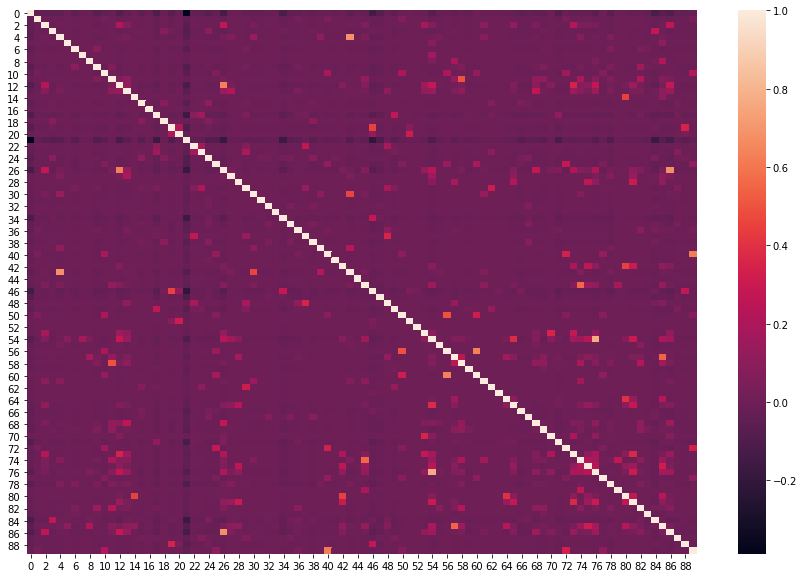

In [728]:
plt.figure(figsize = (15,10))
sns.heatmap(pd.DataFrame(y_train).corr())

In [752]:
# !pip install scikit-multilearn

### Label Powerset Linear SVM

In [1033]:
from skmultilearn.problem_transform import LabelPowerset

In [1034]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', LabelPowerset(LinearSVC(max_iter = 10000)))
])

param_grid = {
#      'clf__classifier__C': [0.1, 1, 10]
}

grid_LP_LinSVC_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LP_LinSVC_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_LP_LinSVC_tfidf.best_params_}")
print(f"Train accuracy: {grid_LP_LinSVC_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LP_LinSVC_tfidf.score(X_test, y_test)}")

Best params: {}
Train accuracy: 0.9819796627622602
Test accuracy: 0.8449817820470354


In [1035]:
y_pred = grid_LP_LinSVC_tfidf.best_estimator_.predict(X_test)
metricsReport('LP LinSVC tfidf', y_test, y_pred)

------LabelPowerSet_LinSVC Model Metrics-----
Accuracy: 0.8450
Hamming Loss: 0.0036
Precision:
  - Macro: 0.6969
  - Micro: 0.9064
Recall:
  - Macro: 0.4948
  - Micro: 0.8272
F1-measure:
  - Macro: 0.5438
  - Micro: 0.8650


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Multi Label kNN

In [1036]:
from skmultilearn.adapt import MLkNN

In [1037]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer(min_df=min_df, max_df=max_df)),
    ('clf', MLkNN(k=10))
])

param_grid = {
    'clf__k': [7,9,11]
}

grid_ML_kNN_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_ML_kNN_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_ML_kNN_tfidf.best_params_}")
print(f"Train accuracy: {grid_ML_kNN_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_ML_kNN_tfidf.score(X_test, y_test)}")

Best params: {'clf__k': 7}
Train accuracy: 0.8315098468271335
Test accuracy: 0.7671414375621066


In [1038]:
y_pred = grid_ML_kNN_tfidf.best_estimator_.predict(X_test)
metricsReport('MLkNN tfidf', y_test, y_pred)

------MLkNN Model Metrics-----
Accuracy: 0.7671
Hamming Loss: 0.0047
Precision:
  - Macro: 0.5576
  - Micro: 0.8670
Recall:
  - Macro: 0.4065
  - Micro: 0.7783
F1-measure:
  - Macro: 0.4500
  - Micro: 0.8203


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Comparison

In [1039]:
# Assign models:
models = []
models.append(('RF tfidf', grid_RF_tfidf.best_estimator_))
models.append(('kNN tfidf', grid_kNN_tfidf.best_estimator_))
models.append(('linSVC tfidf', grid_LinSVC_tfidf.best_estimator_))
models.append(('LP linSVC tfidf`', grid_LP_LinSVC_tfidf.best_estimator_))
models.append(('MLkNN tfidf`', grid_ML_kNN_tfidf.best_estimator_))

# Initiate metrics:
accuracy = []
hamLoss = []
macro_precision = []
macro_recall = []
macro_f1 = []
micro_precision = []
micro_recall = []
micro_f1 = []
auc = []

# Iterate over models and calculate metrics
for name, model in models:
    y_pred = model.predict(X_test)
    
    accuracy.append(accuracy_score(y_test, y_pred))
    hamLoss.append(hamming_loss(y_test, y_pred))
    
    macro_precision.append(precision_score(y_test, y_pred, average='macro'))
    macro_recall.append(recall_score(y_test, y_pred, average='macro'))
    macro_f1.append(f1_score(y_test, y_pred, average='macro'))

    micro_precision.append(precision_score(y_test, y_pred, average='micro'))
    micro_recall.append(recall_score(y_test, y_pred, average='micro'))
    micro_f1.append(f1_score(y_test, y_pred, average='micro'))
 
#     if (name in ['linSVC tfidf']):
#         auc.append(roc_auc_score(y_test , model.decision_function(X_test)))
#     else:
#         auc.append(roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [1040]:
d = {'accuracy_score': accuracy, 
     'hamLoss': hamLoss, 
     'macro_precision': macro_precision,
     'micro_precision': micro_precision,
     'macro_recall' : macro_recall,
     'micro_recall' : micro_recall,
     'macro_f1' : macro_f1,
     'micro_f1' : micro_f1
#      'roc_auc_score' : roc_auc_score
    }

df = pd.DataFrame(data=d)
name, _ = zip(*models)
df.insert(loc=0, column='Method', value=name)
df

,Method,accuracy_score,hamLoss,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1
0,RF tfidf,0.679695,0.005554,0.445774,0.959309,0.131130,0.623397,0.184037,0.755707
1,kNN tfidf,0.752236,0.005119,0.619805,0.856623,0.393773,0.754808,0.449770,0.802499
2,linSVC tfidf,0.814839,0.003323,0.639500,0.946839,0.398712,0.803953,0.469395,0.869565
3,LP linSVC tfidf`,0.844982,0.003559,0.696936,0.906351,0.494810,0.827190,0.543839,0.864963
4,MLkNN tfidf`,0.767141,0.004700,0.557589,0.867004,0.406514,0.778312,0.449981,0.820267


### Take the best classifier and search over tfidf params:

In [819]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer()),
    ('clf', OneVsRestClassifier(LinearSVC(max_iter = 10000)))
])

param_grid = {
    'vectorizer__min_df' : [1],
    'vectorizer__max_df' : [0.5, 0.6, 0.7, 5, 10],
    'vectorizer__ngram_range' : [(1,1), (1,2)]
#     'clf__estimator__C': [1]
}

grid_LinSVC_tfidf_minmax = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_LinSVC_tfidf_minmax.fit(X_train, y_train)

print(f"Best params: {grid_LinSVC_tfidf_minmax.best_params_}")
print(f"Train accuracy: {grid_LinSVC_tfidf_minmax.score(X_train, y_train)}")
print(f"Test accuracy: {grid_LinSVC_tfidf_minmax.score(X_test, y_test)}")

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 79 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 11 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 28 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 56 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 70 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 5 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 51 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 79 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 28 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 56 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 14 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 16 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 42 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label not 48 is present in all training examples.
  str(classes[c]))
C:\Users\prad8002\.conda\envs\py37

Best params: {'vectorizer__max_df': 0.6, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1)}
Train accuracy: 0.9764448448963831
Test accuracy: 0.8148393507784034


In [820]:
y_pred = grid_LinSVC_tfidf_minmax.best_estimator_.predict(X_test)
metricsReport('LP_LinSVC_tfidf', y_test, y_pred)

------LP_LinSVC_tfidf Model Metrics-----
Accuracy: 0.8148
Hamming Loss: 0.0034
Precision:
  - Macro: 0.6281
  - Micro: 0.9458
Recall:
  - Macro: 0.3927
  - Micro: 0.8018
F1-measure:
  - Macro: 0.4624
  - Micro: 0.8679


C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Changing tfidf min/max params has minor influence on results

In [831]:
from sklearn.neural_network import MLPClassifier

In [840]:
pipe = Pipeline(steps=[
    ('vectorizer',  TfidfVectorizer()),
    ('clf', MLPClassifier(hidden_layer_sizes=3, max_iter=1000))
])

param_grid = {
#     'vectorizer__min_df' : [1],
#     'vectorizer__max_df' : [0.5, 0.6, 0.7, 5, 10],
#     'vectorizer__ngram_range' : [(1,1), (1,2)]
# #     'clf__estimator__C': [1]
}

grid_MLP_tfidf = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=1)
grid_MLP_tfidf.fit(X_train, y_train)

print(f"Best params: {grid_MLP_tfidf.best_params_}")
print(f"Train accuracy: {grid_MLP_tfidf.score(X_train, y_train)}")
print(f"Test accuracy: {grid_MLP_tfidf.score(X_test, y_test)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best params: {}
Train accuracy: 0.6416527223580899
Test accuracy: 0.5531632991056641


In [842]:
y_pred = grid_MLP_tfidf.best_estimator_.predict(X_test)
metricsReport('MLP_tfidf', y_test, y_pred)

------MLP_tfidf Model Metrics-----
Accuracy: 0.5532
Hamming Loss: 0.0075
Precision:
  - Macro: 0.0884
  - Micro: 0.9128
Recall:
  - Macro: 0.0447
  - Micro: 0.5061
F1-measure:
  - Macro: 0.0516
  - Micro: 0.6512


# Try to use Doc2Vec instead of TfIdf 

### Linear SVC

In [731]:
# The input data is already pre-processed and vectorized, so we will apply only classifier:
pipe = Pipeline(steps=[
    ('clf', OneVsRestClassifier(LinearSVC(max_iter = 10000)))
])

param_grid = {
#      'clf__estimator__C': [0.1, 1, 10]
}

grid_LinSVC_d2v = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, verbose=2)
grid_LinSVC_d2v.fit(X_train_D2V, y_train)

print(f"Best params: {grid_LinSVC_d2v.best_params_}")
print(f"Train accuracy: {grid_LinSVC_d2v.score(X_train_D2V, y_train)}")
print(f"Test accuracy: {grid_LinSVC_d2v.score(X_test_D2V, y_test)}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 15.4min finished


Best params: {'clf__estimator__C': 0.1}
Train accuracy: 0.6214442013129103
Test accuracy: 0.40642596886386223


In [732]:
y_pred = grid_LinSVC_d2v.best_estimator_.predict(X_test_D2V)
metricsReport('LinSVC Doc2Vec', y_test, y_pred)

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------LinSVC Doc2Vec Model Metrics-----
Accuracy: 0.4064
Hamming Loss: 0.0192
Precision:
  - Macro: 0.1649
  - Micro: 0.3989
Recall:
  - Macro: 0.4369
  - Micro: 0.7743
F1-measure:
  - Macro: 0.2178
  - Micro: 0.5266


In [712]:
sum((y_pred))

array([ 702,    0,    0,    8,    0,    0,    0,    0,    0,   14,    0,
          0,   36,    0,    0,    6,    0,  168,    0,   21,    0, 1097,
          0,    0,   12,    1,  137,    0,    0,    0,    0,    0,    0,
          0,   60,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  214,   11,    0,    5,    0,    0,    0,    0,   13,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   24,    0,    0,    0,    0,    3,
          0,   28,    0,    0,    0,    0,    0,   86,    8,   62,    0,
          0,    0])

In [713]:
sum((y_test))

array([ 719,   23,   14,   30,   18,    1,   18,    2,    3,   28,   18,
          1,   56,   20,    2,   28,    1,  189,    1,   44,    4, 1087,
         10,   17,   35,   30,  149,    4,    1,    5,    6,    4,    7,
          1,  131,   12,   14,    1,   21,    2,   14,    3,    1,   24,
          6,   19,  179,   34,    4,   30,    1,    2,    2,    6,   47,
         11,    1,   10,    1,   12,    7,    3,    3,    1,    3,    9,
         18,    2,   24,   12,    1,   89,    8,   10,   13,   11,   33,
         11,   36,    1,    2,    5,    4,   12,  117,   37,   71,   10,
         14,   13])

# CNN in Keras

In [619]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [515]:
print(f"Reminder: Vocabulary size: {len(corpus_freq)}")

Reminder: Vocabulary size: 19850


In [642]:
# Set parameters:
# For data prep / embedding:
max_features = 5000 # number of features or number of top words to be used
maxlen = 150
embedding_dims = 100

# For convolution:
filters = 100
kernel_size = 2

# For model fit:
batch_size = 10
epochs = 3
validation_split = 0.2

In [613]:
# Define early stopping:
es = EarlyStopping(patience = 4,
                  monitor = 'val_loss',
                  restore_best_weights=True)

### Approach 1: take sequence of words and provide it as an input

In [518]:
# Take topwords as max_features-1 (0 index to be left for padding)
topwords, _= zip(*corpus_freq[:max_features-1])
topwords = list(topwords)

In [519]:
# Create dictionary for words:
word_to_index = dict([(word, index+1) for index, word in enumerate(topwords)])

In [520]:
# Use dictionary to convert tokenized train words into ids
X_train_index = [[word_to_index[word] for word in doc if word in topwords] for doc in tokens_train ]
# Do the same for test
X_test_index = [[word_to_index[word] for word in doc if word in topwords] for doc in tokens_test]

In [521]:
print('Average train sequence length: {}'.format(np.mean(list(map(len, X_train_index)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, X_test_index)), dtype=int)))

Average train sequence length: 72
Average test sequence length: 66


In [522]:
X_train_index = sequence.pad_sequences(X_train_index, maxlen=maxlen)
X_test_index = sequence.pad_sequences(X_test_index, maxlen=maxlen)

In [523]:
X_train_index[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   78,    1,   86,  103,  233,  285,
        268,   78, 1007,  387,   89,   86,   62,   23, 1296,   84,  233,
        203,  526, 1039,    1,    1,  455,  312,  159, 1809,  268,   78,
       2895,  387,  989,  335,   76,  302,  665, 1134,  212,  377,  460,
        209,  849,  155,  831,  397,   12,  297,  203,   84,   12,  331,
         86,  405,  832,   48,   26,   14,  801])

#### After fighting with the piece of code above, I found out that Keras can do it for me... in few simple lines...

In [524]:
from keras.preprocessing.text import Tokenizer

In [525]:
tokenizer = Tokenizer(num_words=max_features)

In [526]:
tokenizer.fit_on_texts(tokens_train) 
sequences_train = tokenizer.texts_to_sequences(tokens_train)
sequences_test = tokenizer.texts_to_sequences(tokens_test)

#### Let's forget about it and move on to our models

### 0-layer neural network

In [527]:
model = Sequential()
model.build()
model.add(Dense(units=y_train.shape[1], input_shape = (X_train_index.shape[1],), activation="sigmoid"))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['binary_accuracy'])
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 90)                13590     
Total params: 13,590
Trainable params: 13,590
Non-trainable params: 0
_________________________________________________________________


In [528]:
model.fit(X_train_index, y_train, 
         batch_size=batch_size,
         epochs=epochs,
         callbacks=[es],
         validation_split = validation_split)

Train on 6215 samples, validate on 1554 samples
Epoch 1/5
6215/6215 [==============================] - 1s 227us/step - loss: 23.2450 - binary_accuracy: 0.9257 - val_loss: 10.5935 - val_binary_accuracy: 0.9686
Epoch 2/5
6215/6215 [==============================] - 1s 182us/step - loss: 7.8494 - binary_accuracy: 0.9711 - val_loss: 6.7995 - val_binary_accuracy: 0.9693
Epoch 3/5
6215/6215 [==============================] - 1s 182us/step - loss: 4.8115 - binary_accuracy: 0.9738 - val_loss: 4.8264 - val_binary_accuracy: 0.9706
Epoch 4/5
6215/6215 [==============================] - 1s 183us/step - loss: 3.2622 - binary_accuracy: 0.9740 - val_loss: 3.9866 - val_binary_accuracy: 0.9721
Epoch 5/5
6215/6215 [==============================] - 1s 164us/step - loss: 2.4961 - binary_accuracy: 0.9742 - val_loss: 3.5835 - val_binary_accuracy: 0.9686


In [529]:
y_pred = model.predict(X_test_index)
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0
metricsReport('NN_0_layer', y_test, y_pred)

------NN_0_layer Model Metrics-----
Accuracy: 0.1043
Hamming Loss: 0.0324
Precision:
  - Macro: 0.0110
  - Micro: 0.1403
Recall:
  - Macro: 0.0176
  - Micro: 0.2631
F1-measure:
  - Macro: 0.0131
  - Micro: 0.1830


### WIth Embedding (FT approach)

In [559]:
model = Sequential()
model.add(Embedding(input_dim=max_features,
                   output_dim=embedding_dims,
                   input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(units=y_train.shape[1], activation="sigmoid"))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['binary_accuracy'])
model.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_47 (Embedding)     (None, 150, 50)           250000    
_________________________________________________________________
global_average_pooling1d_25  (None, 50)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 90)                4590      
Total params: 254,590
Trainable params: 254,590
Non-trainable params: 0
_________________________________________________________________


In [563]:
model.fit(X_train_index, y_train, 
         batch_size=batch_size,
         epochs=epochs,
         callbacks=[es],
         validation_split = validation_split)

Train on 6215 samples, validate on 1554 samples
Epoch 1/5
6215/6215 [==============================] - 3s 461us/step - loss: 0.0318 - binary_accuracy: 0.9918 - val_loss: 0.0292 - val_binary_accuracy: 0.9923
Epoch 2/5
6215/6215 [==============================] - 3s 463us/step - loss: 0.0294 - binary_accuracy: 0.9923 - val_loss: 0.0271 - val_binary_accuracy: 0.9928
Epoch 3/5
6215/6215 [==============================] - 3s 486us/step - loss: 0.0273 - binary_accuracy: 0.9928 - val_loss: 0.0255 - val_binary_accuracy: 0.9931
Epoch 4/5
6215/6215 [==============================] - 4s 589us/step - loss: 0.0256 - binary_accuracy: 0.9931 - val_loss: 0.0242 - val_binary_accuracy: 0.9934
Epoch 5/5
6215/6215 [==============================] - 3s 455us/step - loss: 0.0240 - binary_accuracy: 0.9934 - val_loss: 0.0231 - val_binary_accuracy: 0.9936


In [562]:
y_pred = model.predict(X_test_index)
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0
metricsReport('NN_Embed_FT', y_test, y_pred)

------NN_Embed_FT Model Metrics-----
Accuracy: 0.5028
Hamming Loss: 0.0082
Precision:
  - Macro: 0.0707
  - Micro: 0.9804
Recall:
  - Macro: 0.0202
  - Micro: 0.4140
F1-measure:
  - Macro: 0.0235
  - Micro: 0.5822


### Convolution

In [709]:
model = Sequential()
model.add(Embedding(input_dim=max_features,
                   output_dim=embedding_dims,
                   input_length=maxlen))
model.add(Dropout(0.2))
model.add(Conv1D(filters = 100,
                 kernel_size = 3,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
# model.add(Conv1D(filters = 100,
#                  kernel_size = 3,
#                  padding='valid',
#                  activation='relu'))
# model.add(MaxPooling1D())
# model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(units=250, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=y_train.shape[1], activation="sigmoid"))

model.compile(loss='binary_crossentropy', #weighted_binary_crossentropy
             optimizer='adam',
             metrics=['binary_accuracy'])
model.summary()

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_81 (Embedding)     (None, 150, 100)          500000    
_________________________________________________________________
dropout_75 (Dropout)         (None, 150, 100)          0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 148, 100)          30100     
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 74, 100)           0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 7400)              0         
_________________________________________________________________
dense_119 (Dense)            (None, 250)               1850250   
_________________________________________________________________
dropout_76 (Dropout)         (None, 250)             

In [710]:
model.fit(X_train_index, y_train, 
         batch_size=batch_size,
         epochs=epochs,
         callbacks=[es],
         validation_split = validation_split)

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6215 samples, validate on 1554 samples
Epoch 1/3
6215/6215 [==============================] - 30s 5ms/step - loss: 0.0456 - binary_accuracy: 0.9879 - val_loss: 0.0251 - val_binary_accuracy: 0.9932
Epoch 2/3
6215/6215 [==============================] - 31s 5ms/step - loss: 0.0229 - binary_accuracy: 0.9936 - val_loss: 0.0191 - val_binary_accuracy: 0.9944
Epoch 3/3
6215/6215 [==============================] - 28s 5ms/step - loss: 0.0152 - binary_accuracy: 0.9952 - val_loss: 0.0185 - val_binary_accuracy: 0.9950


In [711]:
y_pred = model.predict(X_test_index)
val = 0.5
y_pred[y_pred>=val] = int(1)
y_pred[y_pred<val] = int(0)
y_pred = y_pred.astype(int)
metricsReport('CNN_Embed', y_test, y_pred)

C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\prad8002\.conda\envs\py37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


------CNN_Embed Model Metrics-----
Accuracy: 0.6804
Hamming Loss: 0.0057
Precision:
  - Macro: 0.1898
  - Micro: 0.9065
Recall:
  - Macro: 0.1043
  - Micro: 0.6576
F1-measure:
  - Macro: 0.1225
  - Micro: 0.7622


In [712]:
sum((y_pred))

array([ 702,    0,    0,    8,    0,    0,    0,    0,    0,   14,    0,
          0,   36,    0,    0,    6,    0,  168,    0,   21,    0, 1097,
          0,    0,   12,    1,  137,    0,    0,    0,    0,    0,    0,
          0,   60,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  214,   11,    0,    5,    0,    0,    0,    0,   13,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   24,    0,    0,    0,    0,    3,
          0,   28,    0,    0,    0,    0,    0,   86,    8,   62,    0,
          0,    0])

In [713]:
sum((y_test))

array([ 719,   23,   14,   30,   18,    1,   18,    2,    3,   28,   18,
          1,   56,   20,    2,   28,    1,  189,    1,   44,    4, 1087,
         10,   17,   35,   30,  149,    4,    1,    5,    6,    4,    7,
          1,  131,   12,   14,    1,   21,    2,   14,    3,    1,   24,
          6,   19,  179,   34,    4,   30,    1,    2,    2,    6,   47,
         11,    1,   10,    1,   12,    7,    3,    3,    1,    3,    9,
         18,    2,   24,   12,    1,   89,    8,   10,   13,   11,   33,
         11,   36,    1,    2,    5,    4,   12,  117,   37,   71,   10,
         14,   13])

In [ ]:
print (metrics.val_f1s)

#### Smallest convolutional network

In [171]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=32, activation='relu', input_shape=(X_train_tfidf.shape[1], 1), ))
model.add(Dense(units=y_train.shape[1], activation="sigmoid" ))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['binary_accuracy'])
model.summary()

NameError: name 'X_train_tfidf' is not defined

#### Explanation of micro and macro average for multiclass:
https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin